In [103]:
#reading the snap and print keys and understanding the HDF5 structure

import h5py
import pandas as pd 

path='/illumina/scratch/deep_learning/lsundaram/singcell_data_jamboree/data/10X/atac_pbmc_500_v1_fastqs'
filename = path+'/atac_pbmc_500_v1_S1.snap'
f=h5py.File(filename, 'r')
print f.keys()
print f['AM']
print f['AM'].values
print f['AM'].values()
print f['AM'].keys()
print f['AM']['1000']
print f['AM']['1000'].keys()
print f['AM']['1000'].values()
print f['AM']['1000']['binChrom']

[u'AM', u'BD', u'FM', u'HD']
<HDF5 group "/AM" (5 members)>
<bound method Group.values of <HDF5 group "/AM" (5 members)>>
[<HDF5 group "/AM/1000" (5 members)>, <HDF5 group "/AM/10000" (5 members)>, <HDF5 group "/AM/5000" (5 members)>, <HDF5 dataset "binSizeList": shape (3,), type "<u4">, <HDF5 dataset "nBinSize": shape (), type "<u4">]
[u'1000', u'10000', u'5000', u'binSizeList', u'nBinSize']
<HDF5 group "/AM/1000" (5 members)>
[u'binChrom', u'binStart', u'count', u'idx', u'idy']
[<HDF5 dataset "binChrom": shape (3137206,), type "|O">, <HDF5 dataset "binStart": shape (3137206,), type "<u4">, <HDF5 dataset "count": shape (7298196,), type "|u1">, <HDF5 dataset "idx": shape (7298196,), type "<u4">, <HDF5 dataset "idy": shape (7298196,), type "<u4">]
<HDF5 dataset "binChrom": shape (3137206,), type "|O">


In [104]:
#making dataframes of bins and counts

temp=pd.DataFrame()
temp['binchr']=f['AM']['1000']['binChrom'][0:]
temp['binstart']=f['AM']['1000']['binStart'][0:]

#

c=pd.DataFrame()
c['idx']=f['AM']['1000']['idx']
c['idy']=f['AM']['1000']['idy']
c['count']=f['AM']['1000']['count']

c.to_csv('/illumina/scratch/deep_learning/lsundaram/singcell_data_jamboree/1000_counts.csv',index=False)
temp.to_csv('/illumina/scratch/deep_learning/lsundaram/singcell_data_jamboree/1000_bin.csv',index=False)


In [105]:
#reading in the counts and bin in pandas 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

counts_matrix=pd.read_csv('/illumina/scratch/deep_learning/lsundaram/singcell_data_jamboree/1000_counts.csv')
bin_matrix=pd.read_csv('/illumina/scratch/deep_learning/lsundaram/singcell_data_jamboree/1000_bin.csv')
bin_matrix['idy']=bin_matrix.index
#bin_matrix['idy']=bin_matrix['idy']+1



In [107]:
#visualize barcode by reads and filter barcodes by the number of reads and bins by number of cells
barcode_counts=pd.DataFrame(counts_matrix.groupby('idx')['count'].sum()).reset_index()
barcode_counts_binary=pd.DataFrame(counts_matrix.groupby('idx')['count'].count()).reset_index()
barcode_counts_binary_fil=barcode_counts_binary[(barcode_counts_binary['count']>500) & ((barcode_counts_binary['count']<60000) )]
#visualize bins with respect to cells
bin_counts=pd.DataFrame(counts_matrix.groupby('idy')['idx'].count()).reset_index()
bin_counts_fil=bin_counts[bin_counts['idx']>5]

   idx  count
0    1     99
1    2    234
2    3    197
3    4    832
4    5     41


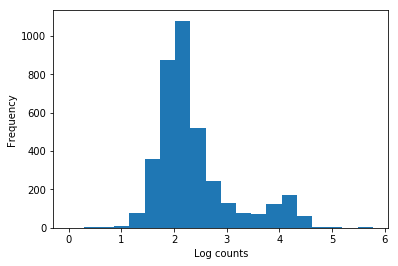

In [15]:
#plotting the distribution of the reads per barcode across all bins
print barcode_counts[0:5]
n, bins, patches = plt.hist(x=barcode_counts.sort_values('count',ascending=False)['count'].apply(lambda x : np.log10(x)), bins=20 )
plt.xlabel('Log counts')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#merging counts and bin matrices and filtering for bad barcode and bins
counts_matrix_merge=counts_matrix.merge(bin_matrix,on='idy')
counts_matrix_merge=counts_matrix_merge[counts_matrix_merge['idx'].isin(barcode_counts_binary_fil['idx'])]
#filtering bins 
counts_matrix_merge=counts_matrix_merge[counts_matrix_merge['idy'].isin(bin_counts_fil['idy'])]
#

In [127]:
#reindexing cells - to know the mapping of new barcode to index and bin to index mapping
relevant_cells=counts_matrix_merge['idx'].drop_duplicates()
relevant_cells=relevant_cells.reset_index()
del relevant_cells['index']
relevant_cells=relevant_cells.reset_index()
print relevant_cells[0:5]
print relevant_cells['index'].max()
#getting this id into main frame 
counts_matrix_merge=counts_matrix_merge.merge(relevant_cells,on='idx')

   index  idx
0      0   17
1      1   40
2      2   69
3      3  107
4      4  177
770


In [126]:
#reindexing bins
relevant_bins=counts_matrix_merge['idy'].drop_duplicates()
relevant_bins=relevant_bins.reset_index()
del relevant_bins['index']
relevant_bins=relevant_bins.reset_index()
print relevant_bins['index'].max()
relevant_bins.columns=['bin_index','idy']
print relevant_bins[0:5]
#getting this id into main frame 
counts_matrix_merge=counts_matrix_merge.merge(relevant_bins,on='idy')
print counts_matrix_merge[0:5]

153225
   bin_index      idy
0          0  1568126
1          1  2955187
2          2    85087
3          3  1841779
4          4   111507
   idx      idy  count binchr  binstart  bin_index
0   17  1568126      1   chr8  20055001          0
1   40  1568126      1   chr8  20055001          0
2   69  1568126      1   chr8  20055001          0
3  107  1568126      4   chr8  20055001          0
4  177  1568126      1   chr8  20055001          0


In [137]:
#building sparse matrix  cell x bin matrix
counts_matrices=np.zeros((771,153226))
#binary_count_matrices=np.zeros((771,temp.shape[0]))
for i in counts_matrix_merge.values:
    counts_matrices[i[-1],i[-2]]=int(i[2])
    #binary_count_matrices[i[0],i[1]]=1

In [144]:
#saving the matrix 
np.save('/illumina/scratch/deep_learning/lsundaram/singcell_data_jamboree/771_150k.npy',counts_matrices)

In [98]:
from sklearn.decomposition import PCA

In [186]:
#pca with 50 components
#normaliZe befoew pca : read depth, tf idf is needed for atac  ( we should also may be binarize it)
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(counts_matrices)

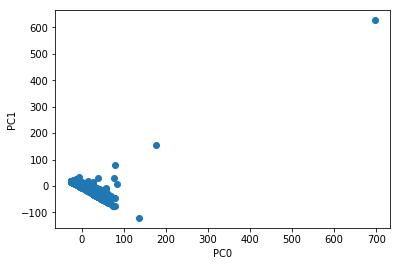

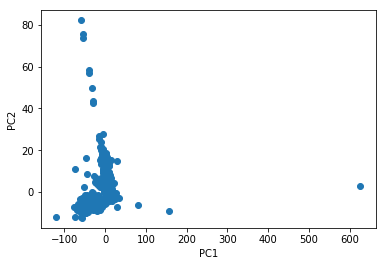

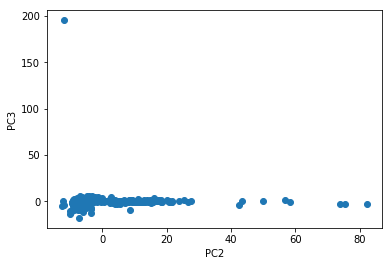

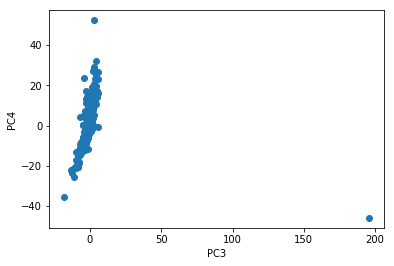

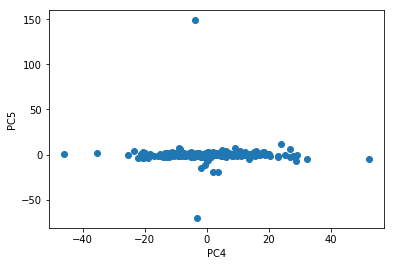

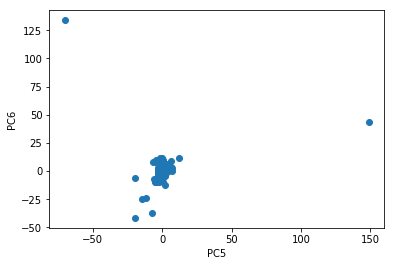

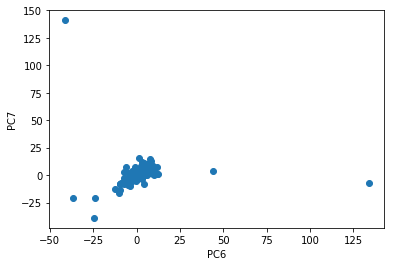

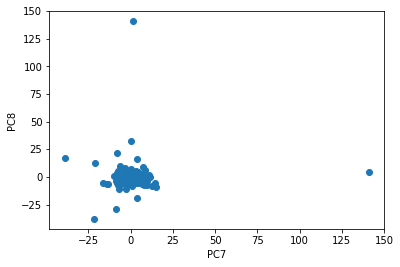

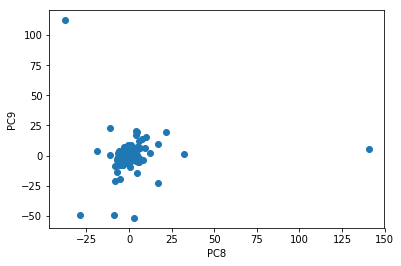

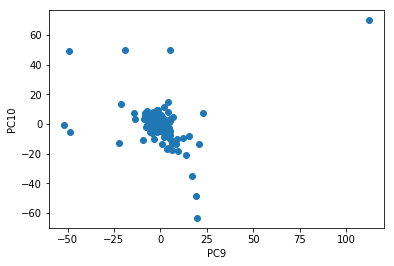

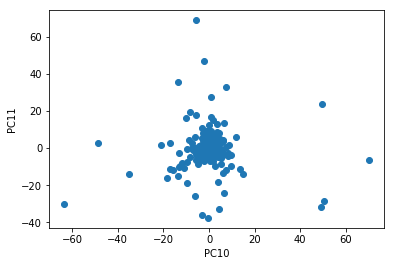

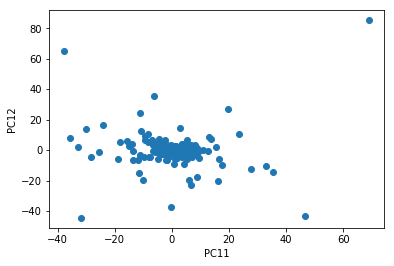

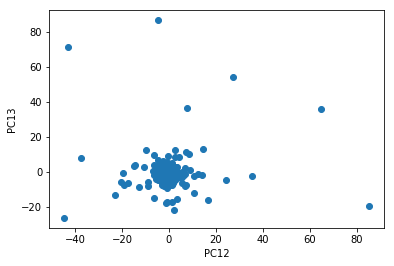

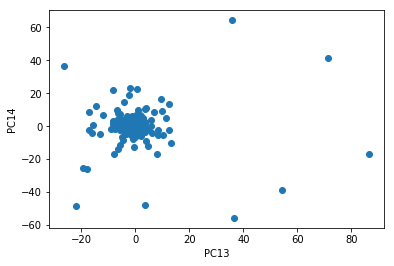

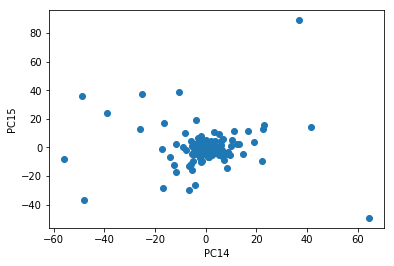

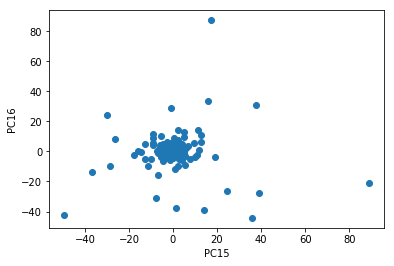

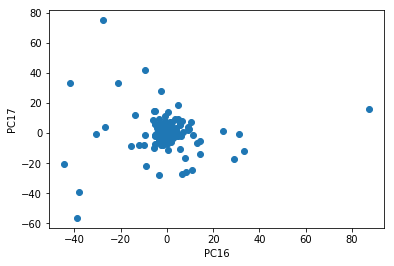

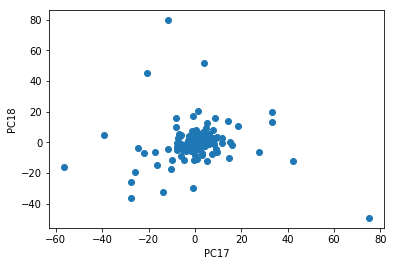

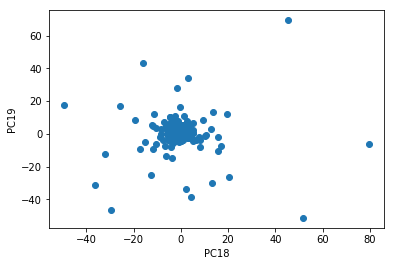

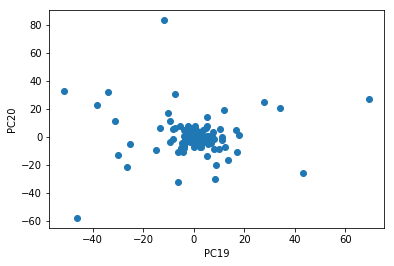

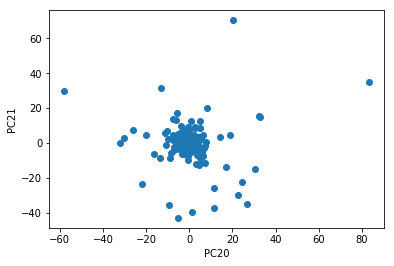

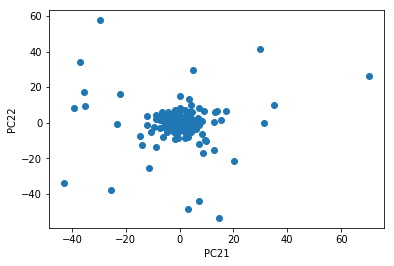

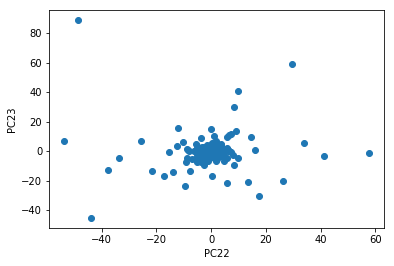

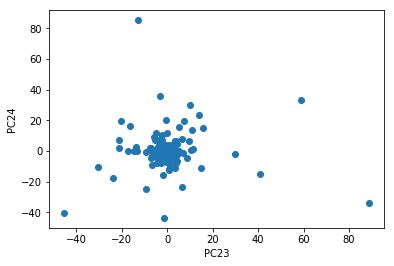

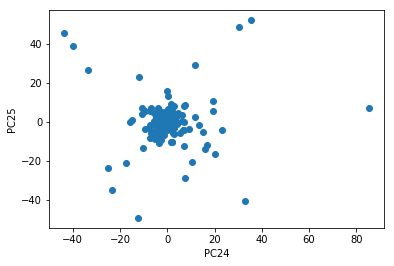

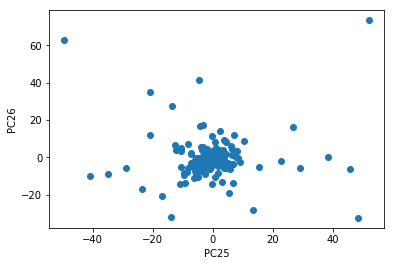

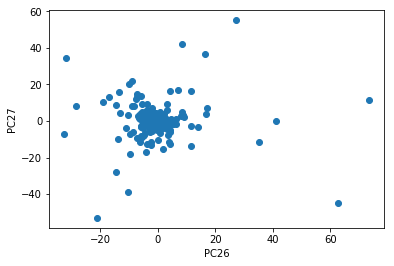

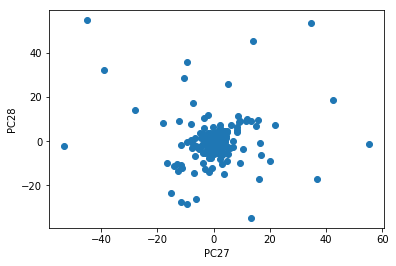

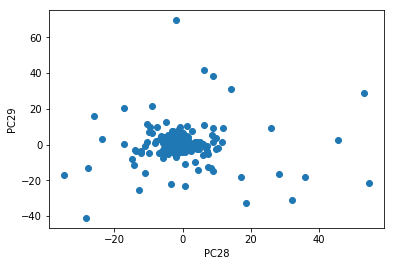

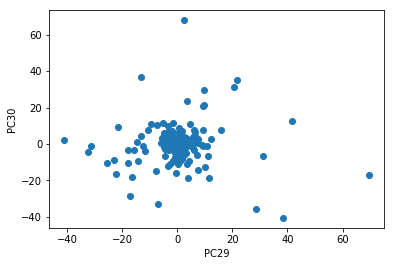

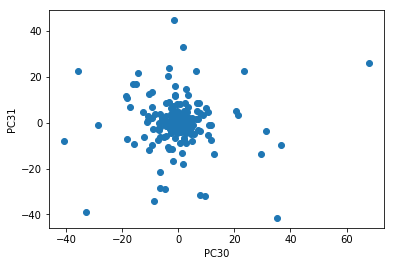

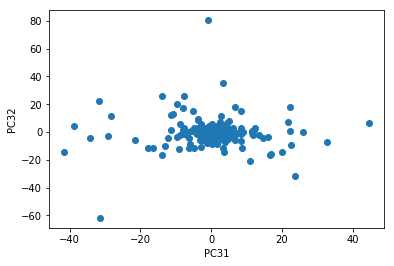

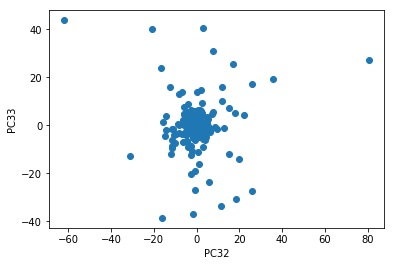

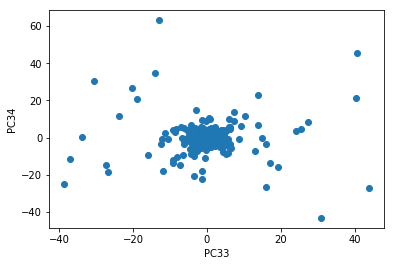

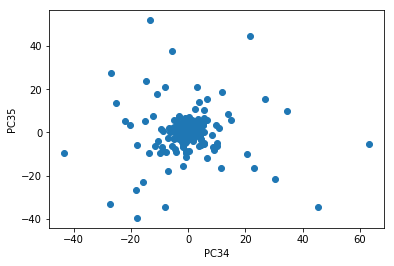

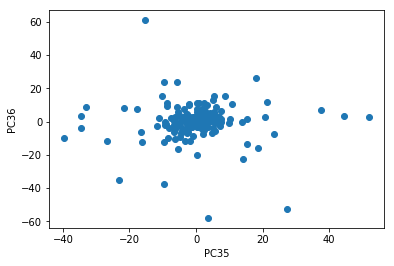

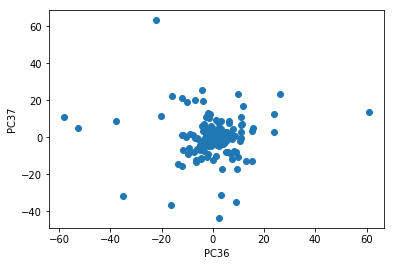

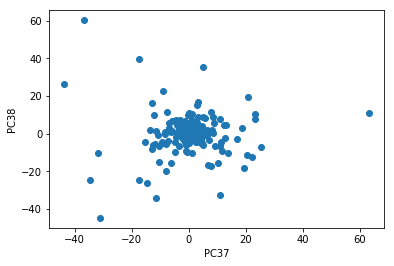

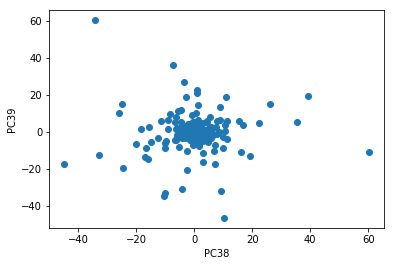

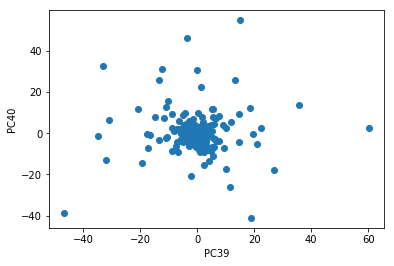

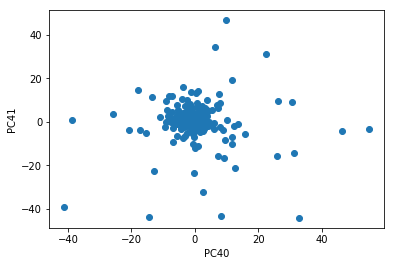

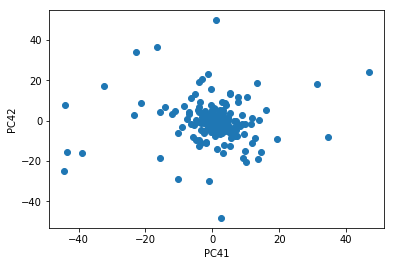

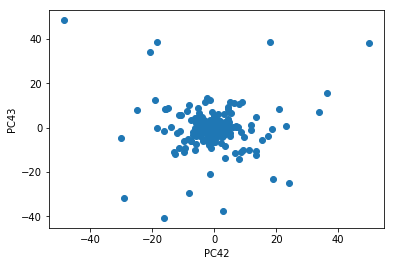

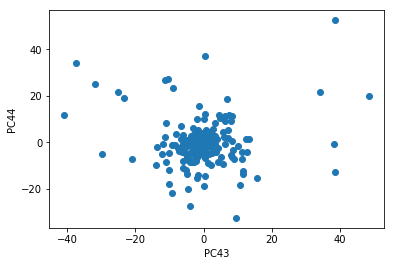

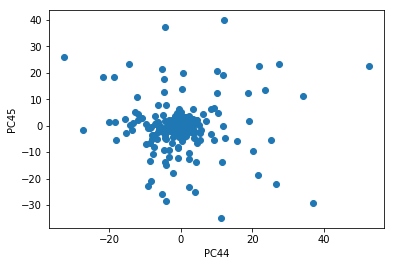

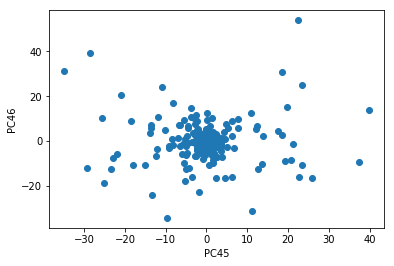

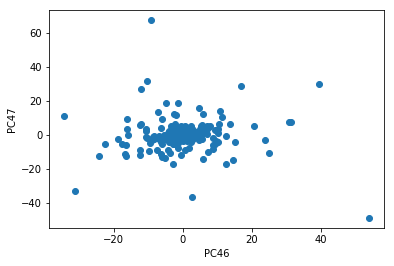

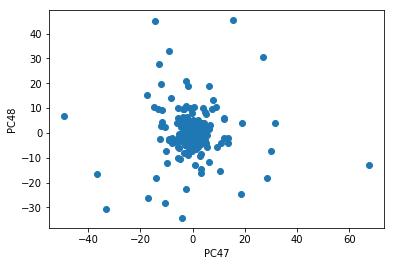

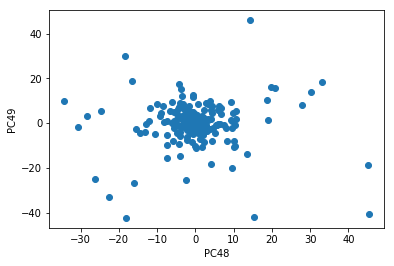

In [193]:
#plotting pcs
for i in range(0,49):
    plt.scatter(pd.DataFrame(principalComponents)[i], pd.DataFrame(principalComponents)[i+1])
    plt.xlabel('PC'+str(i))
    plt.ylabel('PC'+str(i+1))
    plt.show()

(771, 2)


Text(0,0.5,'tsne2')

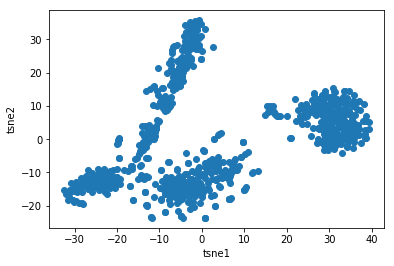

In [195]:
#tsne on pca 
import sklearn
import sklearn.manifold
tsne=sklearn.manifold.TSNE(n_components=2).fit_transform(principalComponents[:,1:])
print tsne.shape
plt.scatter(pd.DataFrame(tsne)[0],pd.DataFrame(tsne)[1])
plt.xlabel('tsne1')
plt.ylabel('tsne2')


In [ ]:
# run clustering on pca, run tsne on pca. then get cell cluster numberf rom clustering and cell coordinates from tsne.
#plot them to gether . 
#clustering louvain or density based graph clustering. 



